### Clouds : test clouds 3D with NEXT MC events

G. Díaz, J. A Hernando


May 2021

In [18]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [19]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [20]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

import clouds.mc_clouds as mcclouds

import invisible_cities.io.dst_io as dio

#import bes.bes           as bes
#import bes.clouds        as clouds
#import next.reco.chits      as chits
#import next.reco.display    as nplay


In [58]:
from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

In [21]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu Jan 13 20:32:14 2022


In [24]:
#import os
import re
import glob
#import numpy  as np
#import pandas as pd
#import tables as tb

#import matplotlib
#from matplotlib import cm
#from matplotlib import pyplot as plt

#import clouds
#import pltclouds

In [33]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/"
filenames = ("Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5", 
             "Tl208_NEW_v1_03_01_nexus_v5_03_04_cut25.beersheba_label_4mm_fid.h5")
filenames = [datadir+file for file in filenames]
print('total files', len(filenames))
print(filenames[0])

total files 2
/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5


In [34]:
def get_dfs(filename):
    
    dfs = {}
    
    dfs['rcvoxels'] = dio.load_dst(filename, 'DATASET', 'BeershebaVoxels')
    dfs['mcvoxels'] = dio.load_dst(filename, 'DATASET', 'MCVoxels')
    dfs['mchits']   = dio.load_dst(filename, 'DATASET', 'MCHits')
    dfs['events']   = dio.load_dst(filename, 'DATASET', 'EventsInfo')
    dfs['bins']     = dio.load_dst(filename, 'DATASET', 'BinsInfo')
    
    return dfs

In [36]:
dfs = get_dfs(filenames[0])

In [72]:
rcvoxels   = dfs['rcvoxels']
mchits     = dfs['mchits']
voxel_size = [float(dfs['bins'][var].unique()) for var in ('size_x', 'size_y', 'size_z')]
print(voxel_size)

[5.0, 5.0, 4.0]


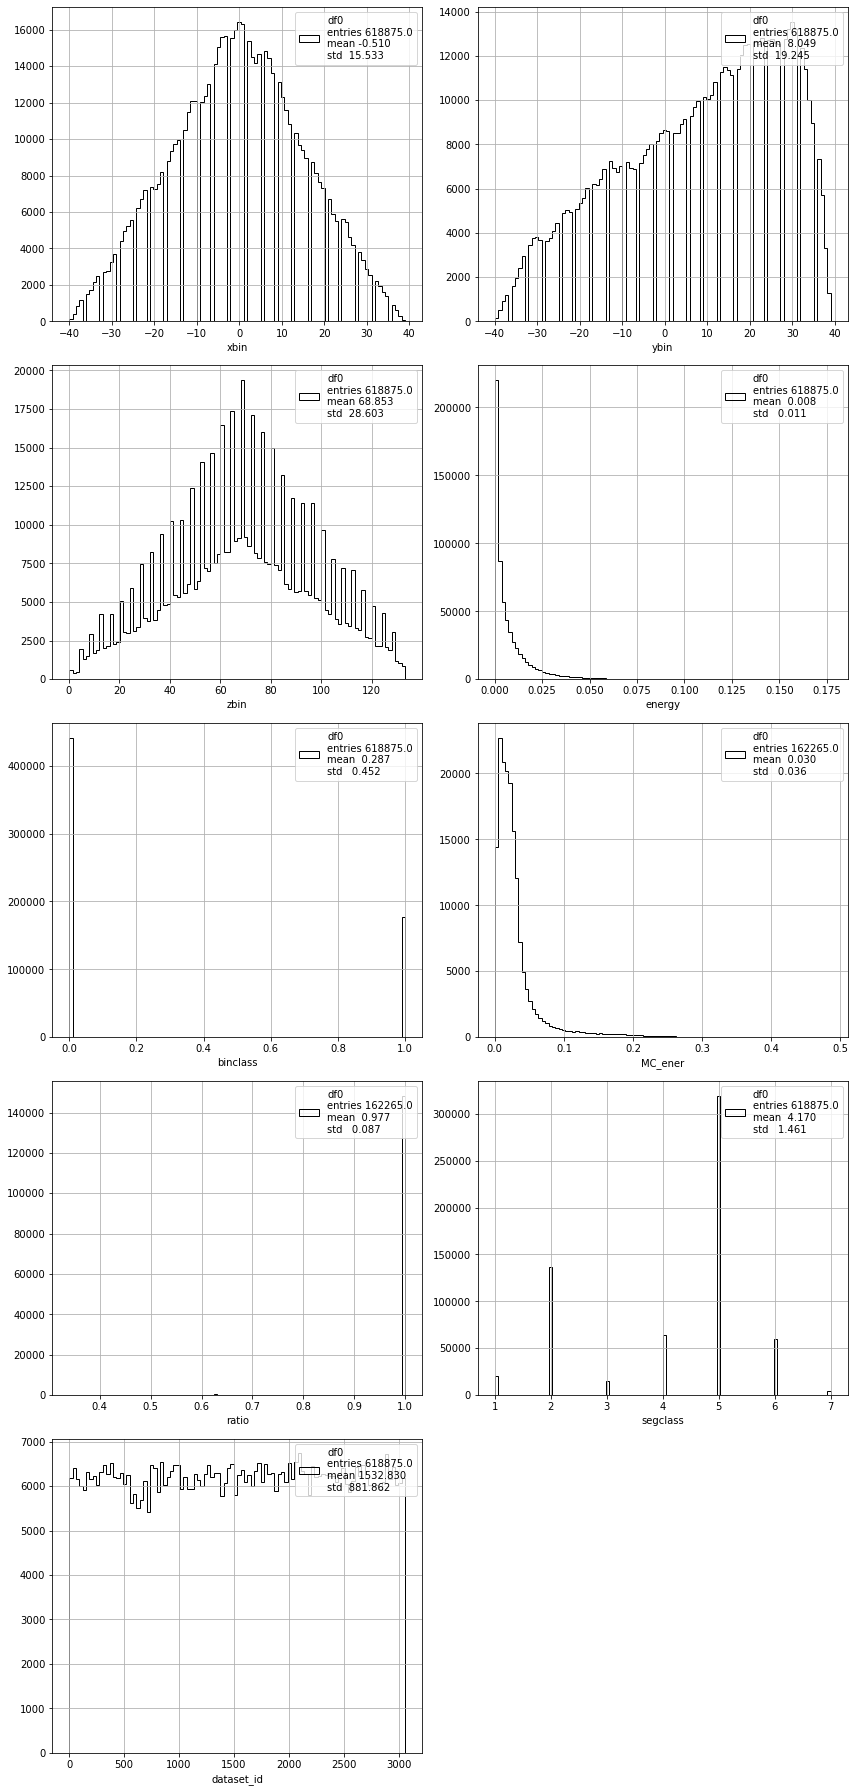

In [60]:
pltext.df_inspect(rcvoxels)

In [77]:
events = rcvoxels['dataset_id'].unique()
event  = events[1]

In [78]:
event_voxels = rcvoxels[rcvoxels.dataset_id == event]
event_hits   = mchits  [mchits  .dataset_id == event]

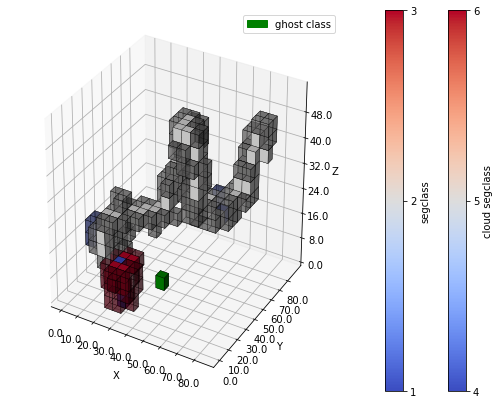

In [79]:
plot_cloud_voxels(event_voxels, voxel_size, opacity = [1, 0.5])

<IPython.core.display.Javascript object>


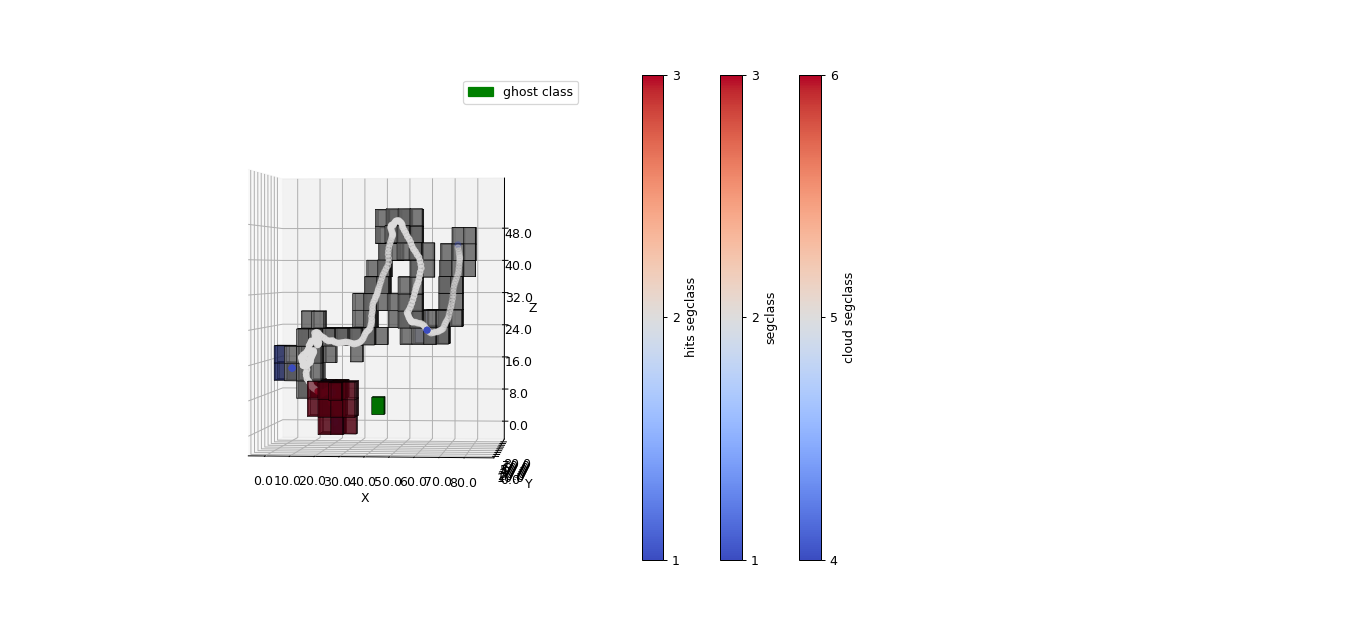

In [81]:
%matplotlib notebook
plot_cloud_voxels_and_hits(event_voxels, event_hits, voxel_size, opacity = [0.6, 0.6])

In [8]:
#filename = np.random.choice(filenames)
#print(filename)
#filename = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/esmeralda_321_0nubb.h5'
#print("File number", get_file_number(filename))

In [9]:
# events good:  3214
# File number 125 , Event 1252
# filename, event  =  360 ,  3604
# filename, event  =  379 ,  3798
# filename, event  =  25 ,  256


# interesing problematic events
# filename, event  =  190 ,  1902

# Interesting events
# filename, event  =  490 ,  4901
# filename, event  =  449 ,  4493



In [175]:
def get_event(filename = None, event = None):
    filename = np.random.choice(filenames) if filename is None else filename

    CHITS_lowTh  = pd.read_hdf(filename, "/CHITS/lowTh") .groupby("event")
    CHITS_highTh = pd.read_hdf(filename, "/CHITS/highTh").groupby("event")

    MChits = pd.read_hdf(filename, "MC/hits").groupby("event_id")
    data_events = pd.read_hdf(filename, "Run/events")
    event       = np.random.choice(data_events["evt_number"]) if event is None else event
    print('filename, event  = ', get_file_number(filename), ', ', event)
    
    low  = CHITS_lowTh .get_group(event)
    high = CHITS_highTh.get_group(event)
    true = MChits      .get_group(event)

    x, y, z, w = split_hits(low, weight="E")
    coors = (x, y, z)
    ene   = 1e-5 * w

    mcx, mcy, mcz, mcid = true["x"].values, true["y"].values, dv*true["z"].values, true['particle_id'].values
    mccoors = (mcx, mcy, mcz)
    mcene, mctime = true["energy"].values, true['time'].values
    
    print('Energy MC ', np.sum(mcene), ', RC ', np.sum(ene))
    
    if (np.sum(ene) <= 2.1): 
        return get_event()
    
    return coors, ene, mccoors, mcene, mctime, mcid
    

In [176]:
coors, ene, mccoors, mcene, mctime, mcid = get_event()

filename, event  =  93 ,  937
Energy MC  1.3678263 , RC  1.0946381882715226
filename, event  =  74 ,  749
Energy MC  2.4578302 , RC  2.3000968308258054


## Draw MC event

<IPython.core.display.Javascript object>


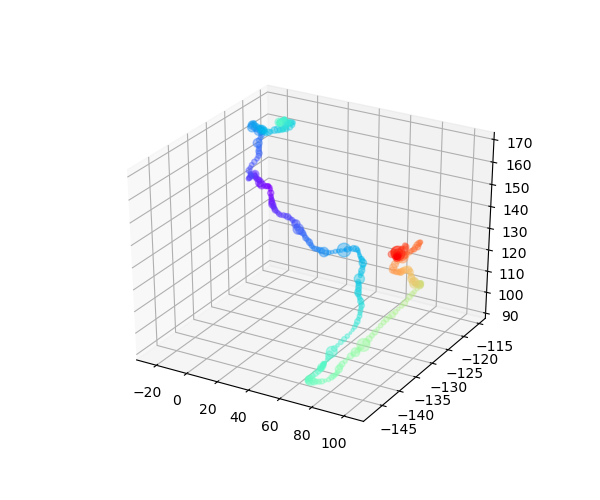

In [177]:
cells_select = clouds.cells_select
subplot = pltext.canvas(1, 1)
plt.gcf().add_subplot(1, 1 ,1, projection = '3d')
scale  = mctime/np.max(mctime)
size   = mcene/np.max(mcene)
plt.gca().scatter(*mccoors, c = scale, s = 100 * size, marker = 'o', alpha = 0.4);
#for i in np.unique(mcid):
#    sel = mcid == i
#    plt.gca().scatter(*cells_select(mccoors, sel),s = 100 * size[sel], marker = 'o', alpha = 0.4);

In [179]:
#pltclouds.plot_tview(mccoors, mcene, mctime)

## Draw Reco

In [180]:
steps  = (10, 10, 2)
bins, mask, cells, df = clouds.clouds(coors, steps, ene)

In [181]:
#steps  = (2, 2, 2)
#bins, mask, cells, df = clouds.clouds(mccoors, steps, mcene)

<IPython.core.display.Javascript object>


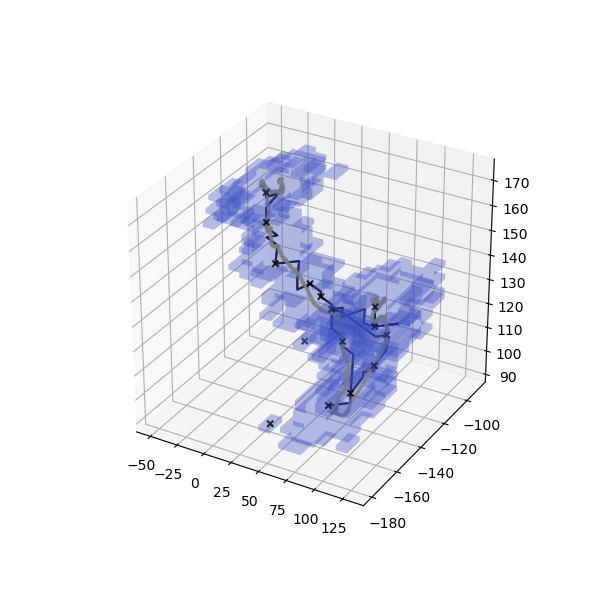

In [182]:
plt.figure(figsize = (6, 6))
pltclouds.draw_cloud(cells, bins, df);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.5, c = 'gray');

## MC 

In [183]:
dft = mcclouds.mctrue(bins, mask, cells, df, mccoors, mcene, mctime,  mcid)


<IPython.core.display.Javascript object>


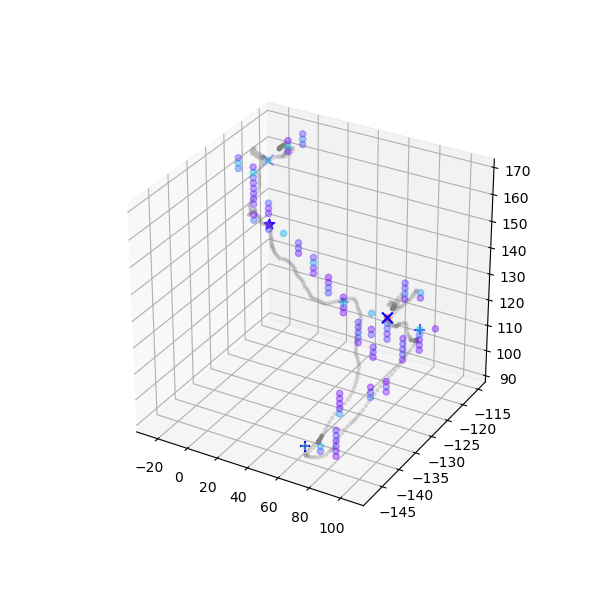

In [190]:
cells_select = clouds.cells_select
ismc         = dft.mc       .values
cene         = dft.mcene    .values
ctime        = dft.mctime   .values
cmcid        = dft.mcid     .values
uextr        = dft.mcextreme.values

plt.figure(figsize = (6, 6))
ax = plt.gca(projection = '3d')
ax.scatter(*cells_select(cells, ismc), c = cene[ismc], alpha = 0.4);
#ax.scatter(*cells_select(cells, ctnodes), marker = '+', c = 'black', s = 60);
#ax.scatter(*cells_select(cells, ctnodes1), marker = 'x', c = 'black', s = 60);
ax.scatter(*cells_select(cells, uextr == 0), marker = '*', c = 'blue', s = 60);
ax.scatter(*cells_select(cells, uextr == 1), marker = 'x', c = 'blue', s = 60);
ax.scatter(*cells_select(cells, uextr > 1), marker = '+', c = 'blue', s = 60);

#pltclouds.draw_grad(cells, epath, alpha = 0.8);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

In [192]:
print(ismc[np.argwhere(uextr >= 0)])
print(cene[np.argwhere(uextr == 0)])
print(cene[np.argwhere(uextr == 1)])
print(cmcid[np.argwhere(uextr == 0)])
print(cmcid[np.argwhere(uextr == 1)])
print(ctime[np.argwhere(uextr == 0)])
print(ctime[np.argwhere(uextr == 1)])

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]]
[[0.00971047]]
[[0.08668308]
 [0.21810043]]
[[1.33333333]]
[[1.]
 [2.]]
[[0.00481155]]
[[0.37578892]
 [0.88181825]]


## Time graph

<IPython.core.display.Javascript object>


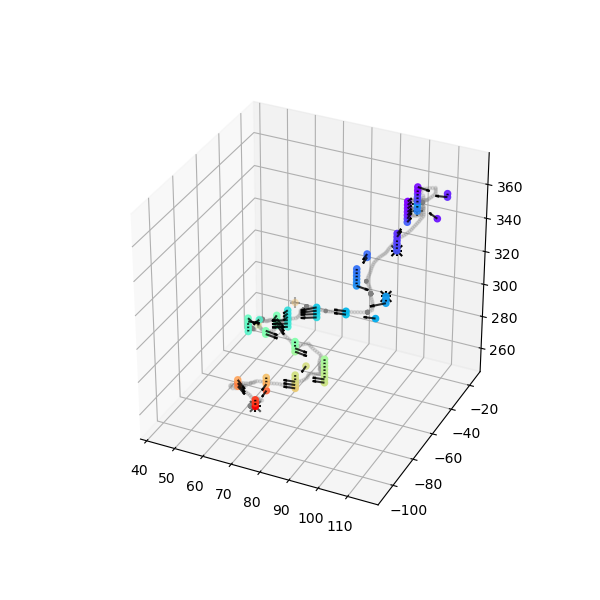

In [130]:
cells_select = clouds.cells_select
ctime   = dft.mctime.values
ctnodes = dft.mctimeextr.values >= 0
ctnodes1 = dft.mctimeextr.values == 1

plt.figure(figsize = (6, 6))
ax = plt.gca(projection = '3d')
ax.scatter(*cells, c = ctime);
ax.scatter(*cells_select(cells, ctnodes), marker = '+', c = 'black', s = 60);
ax.scatter(*cells_select(cells, ctnodes1), marker = 'x', c = 'black', s = 60);
pltclouds.draw_grad(cells, epath, alpha = 0.8);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

In [74]:
print('degrees ', degrees)
print('nlink \n', nlink)

degrees  [1 2 1 2]
nlink 
 [[ -1  -1  -1 561]
 [ -1  -1 500 559]
 [ -1 426  -1  -1]
 [560 560  -1  -1]]


In [47]:
for name in ('mceneextr', 'mctimeextr'):
    vals = dft[name].values
    print(name[:5], ' nodes total  ', np.sum(vals > 0))
    print(name[:5], ' nodes iso    ', np.sum(vals == 0))
    print(name[:5], ' nodes single ', np.sum(vals == 1))
    print(name[:5], ' nodes chain  ', np.sum(vals >  1))

mcene  nodes total   12
mcene  nodes iso     0
mcene  nodes single  1
mcene  nodes chain   11
mctim  nodes total   3
mctim  nodes iso     0
mctim  nodes single  2
mctim  nodes chain   1


In [23]:
node, epath, isnode  = graphs._emap(bins, mask, cells, ctime)

In [29]:
pltclouds.draw_grad(cells, epath);

In [196]:
np.sum(dft.mceneextr.values >0)

22

## All nodes

<IPython.core.display.Javascript object>


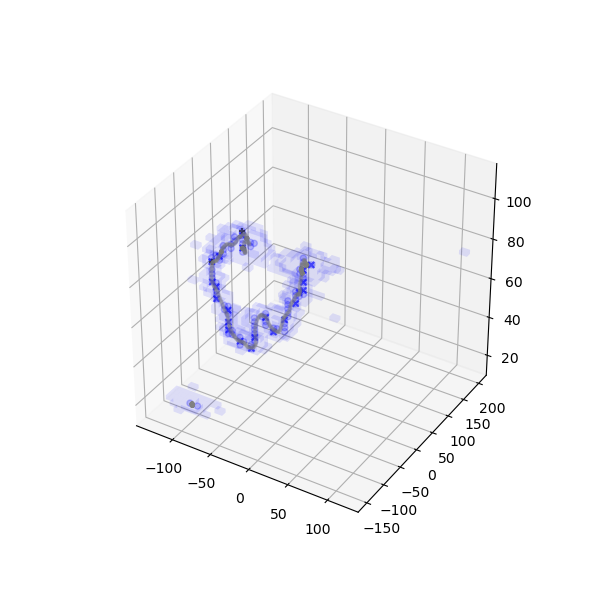

In [197]:
cells_select = clouds.cells_select
plt.figure(figsize = (6, 6))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05);
istrue = dft.ismc.values
plt.gca().scatter(*cells_select(cells, istrue), marker = 'o', alpha = 0.2);
eisext = dft.mceneextr.values > 0
plt.gca().scatter(*cells_select(cells, eisext), marker = 'x', alpha = 0.6, c = 'blue');
eisext = dft.mctimeextr.values > 0
plt.gca().scatter(*cells_select(cells, eisext), marker = '+', alpha = 0.6, c = 'black');
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

## Nodes with 1 degree

In [198]:
for name in ('mceneextr', 'mctimeextr'):
    vals = dft[name].values
    print(name[:5], ' nodes total  ', np.sum(vals > 0))
    print(name[:5], ' nodes iso    ', np.sum(vals == 0))
    print(name[:5], ' nodes single ', np.sum(vals == 1))
    print(name[:5], ' nodes chain  ', np.sum(vals >  1))

mcene  nodes total   22
mcene  nodes iso     1
mcene  nodes single  4
mcene  nodes chain   18
mctim  nodes total   3
mctim  nodes iso     4
mctim  nodes single  2
mctim  nodes chain   1


<IPython.core.display.Javascript object>


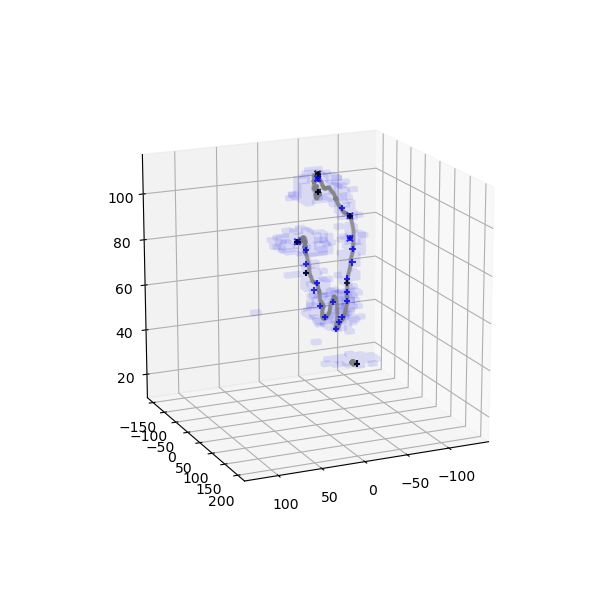

In [199]:
cells_select = clouds.cells_select
plt.figure(figsize = (6, 6))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05);
for k, name in enumerate(('mcene', 'mctime')):
    vals = dft[name+'extr'].values
    for i, isel in enumerate((vals >= 0, vals == 1)):
        c  = 'blue' if k == 0 else 'black'
        mk = '+'    if i == 0 else 'x' 
        plt.gca().scatter(*cells_select(cells, isel), marker = mk, alpha = 0.8, c = c);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.4, c = 'gray');

## Properties of the extremes

<IPython.core.display.Javascript object>


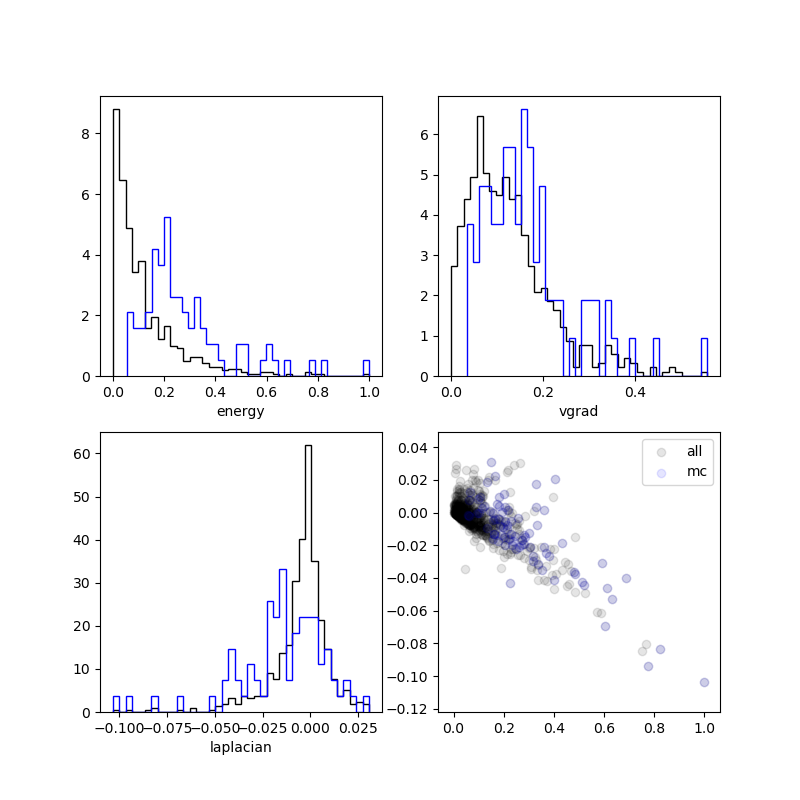

In [188]:
isall   = dft.ismc      .values >= 0
ismc    = dft.ismc      .values
isxextr = dft.mceneextr .values > 0
istextr = dft.mctimeextr.values > 0

plt.figure(figsize = (8, 8));

nbins   = 40
density = True
for isel, name in zip([isall, ismc], ('all', 'mc', 'xextr', 'textr')):
    plt.subplot(2, 2, 1)
    plt.hist(dft.energy[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('energy')
    plt.subplot(2, 2, 2)
    plt.hist(dft.vgrad[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('vgrad')
    plt.subplot(2, 2, 3)
    plt.hist(dft.laplacian[isel], nbins, label = name, density = density, histtype = 'step')
    plt.xlabel('laplacian')
    plt.subplot(2, 2, 4)
    plt.scatter(dft.energy[isel], dft.laplacian[isel], alpha = 0.1, label = name)
plt.legend()

<IPython.core.display.Javascript object>


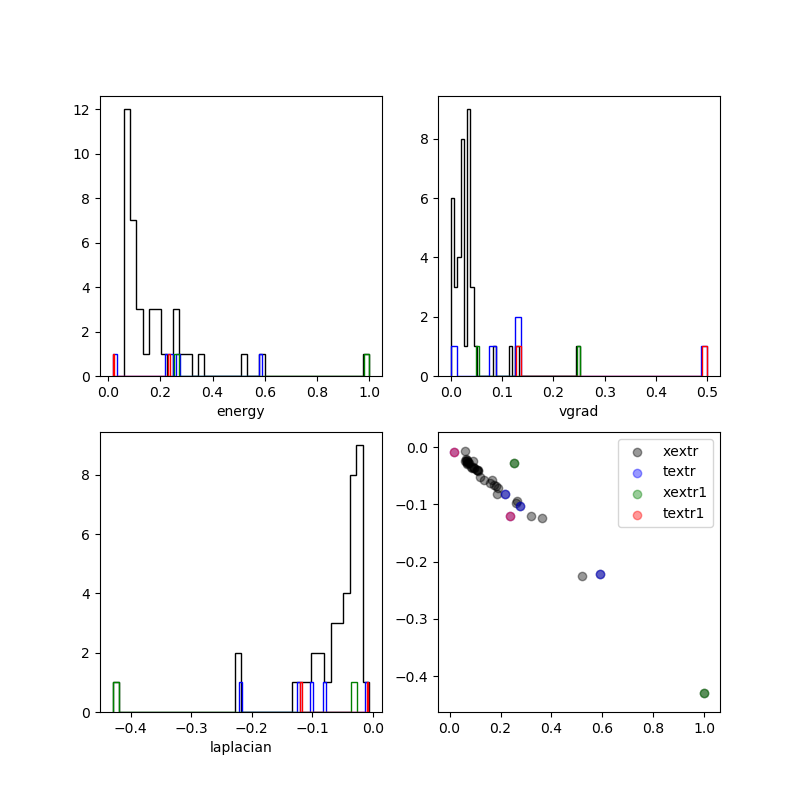

In [178]:
isxextr  = dft.mceneextr .values  >=0
istextr  = dft.mctimeextr.values  >=0
isxextr1 = dft.mceneextr .values  == 1
istextr1 = dft.mctimeextr.values  == 1

plt.figure(figsize = (8, 8));

nbins   = 40
density = False
for isel, name in zip([isxextr, istextr, isxextr1, istextr1], ('xextr', 'textr', 'xextr1', 'textr1')):
    if (np.sum(isel) <= 0): continue
    plt.subplot(2, 2, 1)
    plt.hist(dft.energy[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('energy')
    plt.subplot(2, 2, 2)
    plt.hist(dft.vgrad[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('vgrad')
    plt.subplot(2, 2, 3)
    plt.hist(dft.laplacian[isel], nbins, label = name, density = density, histtype = 'step')
    plt.xlabel('laplacian')
    plt.subplot(2, 2, 4)
    plt.scatter(dft.energy[isel], dft.laplacian[isel], alpha = 0.4, label = name)
plt.legend()